In [ ]:
import pandas as pd
import numpy as np
from random import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

Document link: https://colab.research.google.com/drive/1H0fwT7oY_XCVeGNjt0hlzdsxeUKtQw2s?usp=sharing

### Data Loading

In [ ]:
# Read the CSV files
weather_data = pd.read_csv('/content/weather_data.csv')
park_data = pd.read_csv('/content/park_visitation.csv')

print(weather_data.shape,park_data.shape)
print(weather_data.head(),park_data.head())


(1096, 167) (364, 2)
  DATE_CALENDAR  CLOUD_BASE_HEIGHT_24HR_DEP  CLOUD_BASE_HEIGHT_AVG  \
0    2021-03-13                       -1376                 1063.0   
1    2021-03-14                         255                 1318.0   
2    2021-03-15                        7448                 8767.0   
3    2021-03-16                       -6705                 2061.0   
4    2021-03-17                         639                 2700.0   

   CLOUD_BASE_HEIGHT_MAX  CLOUD_BASE_HEIGHT_MIN  CLOUD_COVER_24HR_DEP  \
0                 1063.0                 1063.0                 -0.01   
1                 2482.0                  586.0                 -0.03   
2                11406.0                 6184.0                  0.18   
3                 5232.0                  424.0                  0.55   
4                 7604.0                  680.0                 -0.07   

   CLOUD_COVER_AVG  CLOUD_COVER_MAX  CLOUD_COVER_MIN  \
0             0.18             0.74             0.00   
1      

Merge weather and park data based on Date

In [ ]:
# Merging the datasets on the date column
aligned_data = pd.merge(park_data, weather_data, left_on='DATE', right_on='DATE_CALENDAR', how='left')
print(aligned_data.shape)


(364, 169)


### Data Cleaning
Rule based on percentage of missing values

1.Above 90% , drop the entire column

2.Between 50% to 90%, fill the column with string 'None' or number 0

3.Between 5% to 50% , fill the column with mean or mode

4.Below 5%, drop the row that contains null value

In [ ]:
def clean_dataframe(df):
    # Step 1: Drop columns where more than 90% of the values are missing
    threshold_90 = len(df) * 0.9
    df = df.dropna(thresh=threshold_90, axis=1)

    # Step 2: Handle columns where 50% to 90% of the values are missing
    threshold_50 = len(df) * 0.5
    columns_50_to_90 = df.columns[(df.isnull().sum() >= threshold_50) & (df.isnull().sum() < threshold_90)]
    for col in columns_50_to_90:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna('None')
        else:
            df[col] = df[col].fillna(0)

    # Step 3: Drop rows where less than 5% of the values are missing
    threshold_5_percent = len(df.columns) * 0.05
    columns_less_5_percent = df.columns[df.isnull().sum() < threshold_5_percent]
    df = df.dropna(subset=columns_less_5_percent, how='any')

    # Step 4: Fill the remaining missing values with mode for objects and mean for numerical columns
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype == 'object':
                mode_value = df[col].mode()[0]
                df[col] = df[col].fillna(mode_value)
            else:
                mean_value = df[col].mean()
                df[col] = df[col].fillna(mean_value)

    return df

Check if there are still missing value after cleaning

In [ ]:
aligned_data = clean_dataframe(aligned_data)

# Check the missing data
final_missing = aligned_data.isnull().sum()
final_missing_summary = final_missing[final_missing > 0]

print(f'Check for missing value:{final_missing_summary}\n')

aligned_data.info()

Check for missing value:Series([], dtype: int64)

<class 'pandas.core.frame.DataFrame'>
Index: 359 entries, 0 to 363
Columns: 158 entries, DATE to WIND_SPEED_MIN
dtypes: bool(2), float64(140), int64(9), object(7)
memory usage: 441.0+ KB


### Data Explore

The number of visitors may vary based on a few key factors which I will make some assumptions to investigate.
1. Temperature
2. Rainy weather
3. Snowy weather
4. UV Index

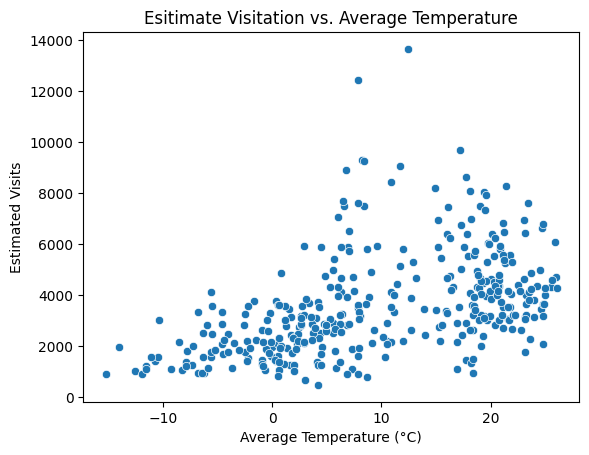

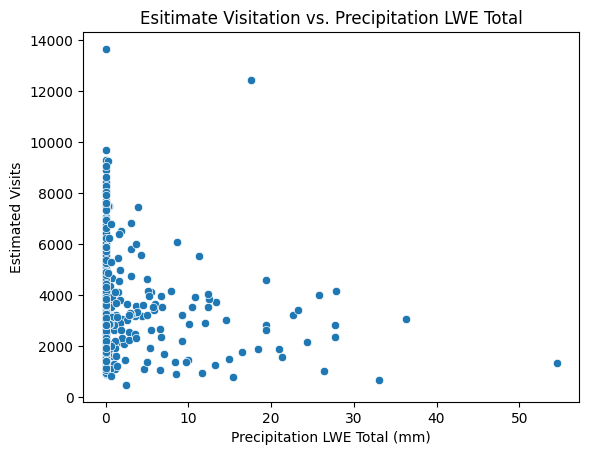

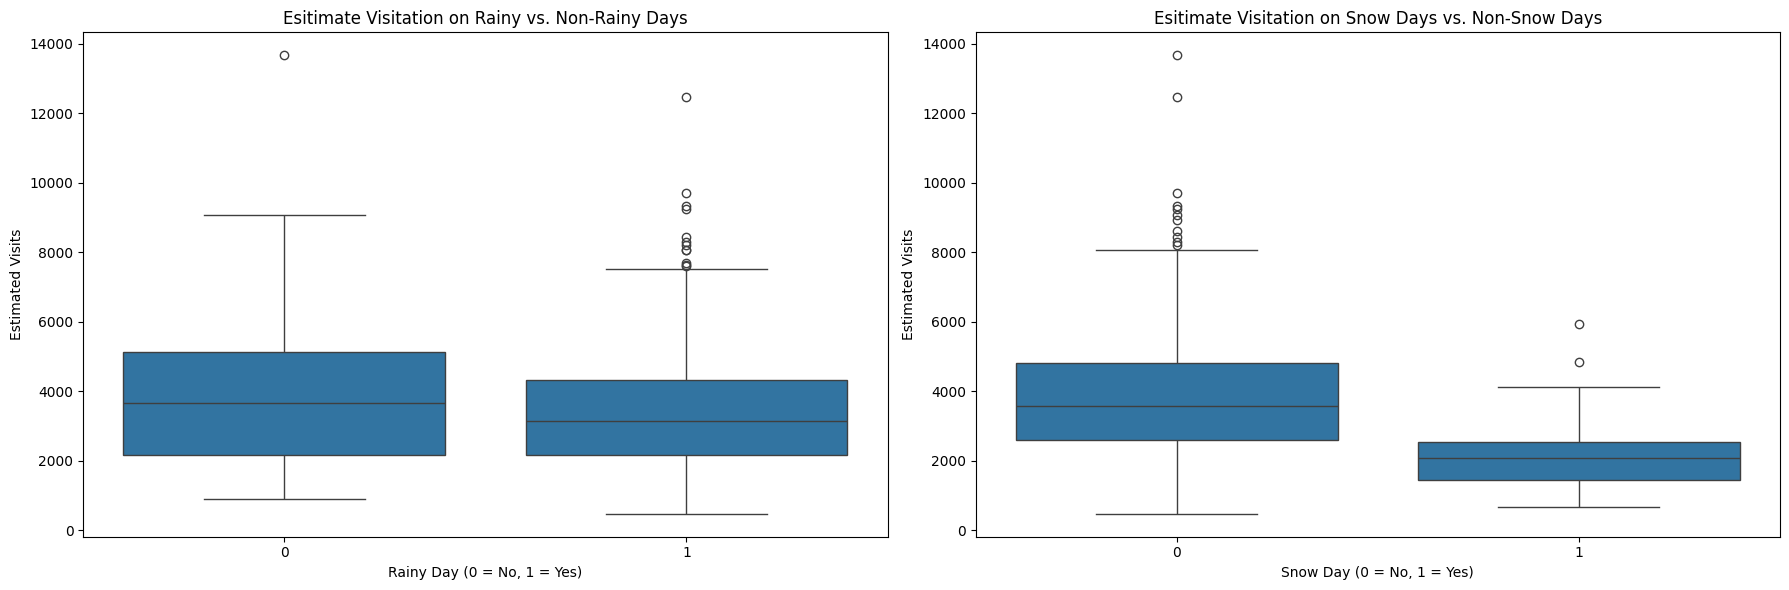

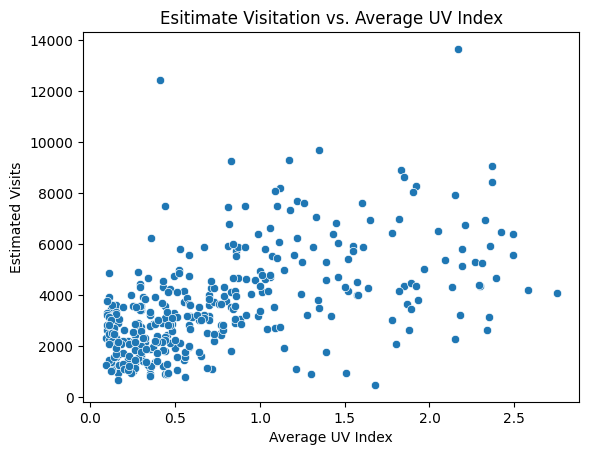

In [ ]:
# Key columns to investigate
exploration_columns = ['ESTIMATED_VISITS', 'TEMPERATURE_AVG', 'PRECIPITATION_LWE_TOTAL', 'HAS_PRECIPITATION', 'INDEX_UV_AVG', 'HAS_SNOW']

exploration_data = aligned_data[exploration_columns]

# Scatter plot between estimated visits and average temperature
sns.scatterplot(x='TEMPERATURE_AVG', y='ESTIMATED_VISITS', data=exploration_data)
plt.title('Esitimate Visitation vs. Average Temperature')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Estimated Visits')
plt.show()

# Scatter plot between estimated visits and precipitation LWE total
sns.scatterplot(x='PRECIPITATION_LWE_TOTAL', y='ESTIMATED_VISITS', data=exploration_data)
plt.title('Esitimate Visitation vs. Precipitation LWE Total')
plt.xlabel('Precipitation LWE Total (mm)')
plt.ylabel('Estimated Visits')
plt.show()

# Convert boolean columns to numeric col (True to 1, False to 0)
exploration_data['HAS_PRECIPITATION'] = exploration_data['HAS_PRECIPITATION'].astype(int)
exploration_data['HAS_SNOW'] = exploration_data['HAS_SNOW'].astype(int)

# Plotting relationships with weather condition (rainy day, snow day)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Rainy Day vs. Visitation
sns.boxplot(x='HAS_PRECIPITATION', y='ESTIMATED_VISITS', data=exploration_data, ax=axes[0])
axes[0].set_title('Esitimate Visitation on Rainy vs. Non-Rainy Days')
axes[0].set_xlabel('Rainy Day (0 = No, 1 = Yes)')
axes[0].set_ylabel('Estimated Visits')

# Snow Day vs. Visitation
sns.boxplot(x='HAS_SNOW', y='ESTIMATED_VISITS', data=exploration_data, ax=axes[1])
axes[1].set_title('Esitimate Visitation on Snow Days vs. Non-Snow Days')
axes[1].set_xlabel('Snow Day (0 = No, 1 = Yes)')
axes[1].set_ylabel('Estimated Visits')
plt.tight_layout()
plt.show()

# Scatter plot for UV Index vs. Visitation
sns.scatterplot(x='INDEX_UV_AVG', y='ESTIMATED_VISITS', data=exploration_data)
plt.title('Esitimate Visitation vs. Average UV Index')
plt.xlabel('Average UV Index')
plt.ylabel('Estimated Visits')
plt.show()


### Outlier Inspection

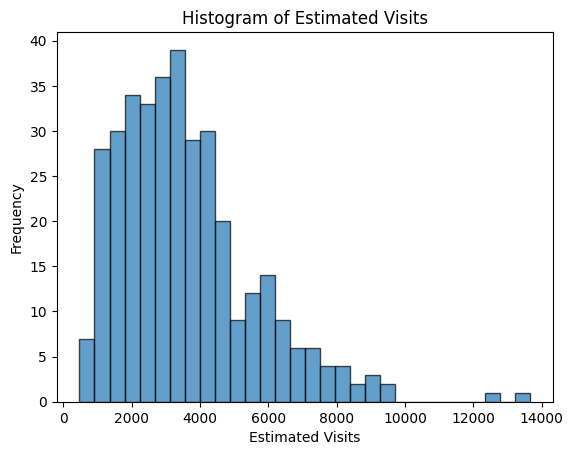

In [ ]:
# Histogram of ESTIMATED_VISITS
plt.hist(aligned_data['ESTIMATED_VISITS'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Estimated Visits')
plt.xlabel('Estimated Visits')
plt.ylabel('Frequency')
plt.show()


Define the threshold to drop the outlier data that is beyond **95%** percentile

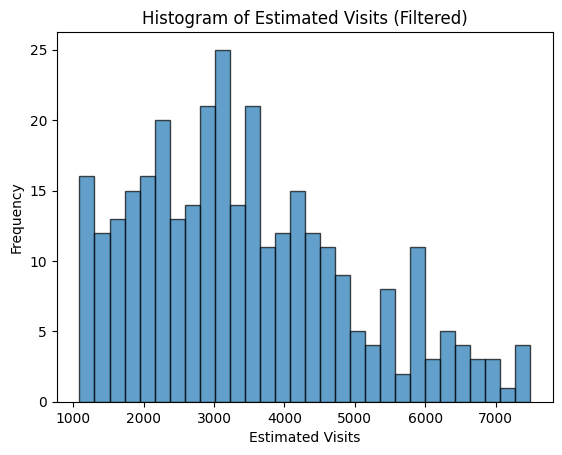

(323, 158)


In [ ]:
# Statistical summary of ESTIMATED_VISITS
visits_summary = aligned_data['ESTIMATED_VISITS'].describe(percentiles=[.05, .25, .75, .95])
visits_summary

# Define thresholds
lower_threshold = visits_summary['5%']
upper_threshold = visits_summary['95%']

# Filter the data with threshold
aligned_data = aligned_data[
                            (aligned_data['ESTIMATED_VISITS'] >= lower_threshold) &
                            (aligned_data['ESTIMATED_VISITS'] <= upper_threshold)
                            ]

# Plot the histogram of the threshold filtered data
plt.hist(aligned_data['ESTIMATED_VISITS'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Estimated Visits (Filtered)')
plt.xlabel('Estimated Visits')
plt.ylabel('Frequency')
plt.show()

print(aligned_data.shape)


### Correlation analysis

By calculate the correlation bettween each feature colmun with the target column **(estimated visits)** to filter out features that is less correlated

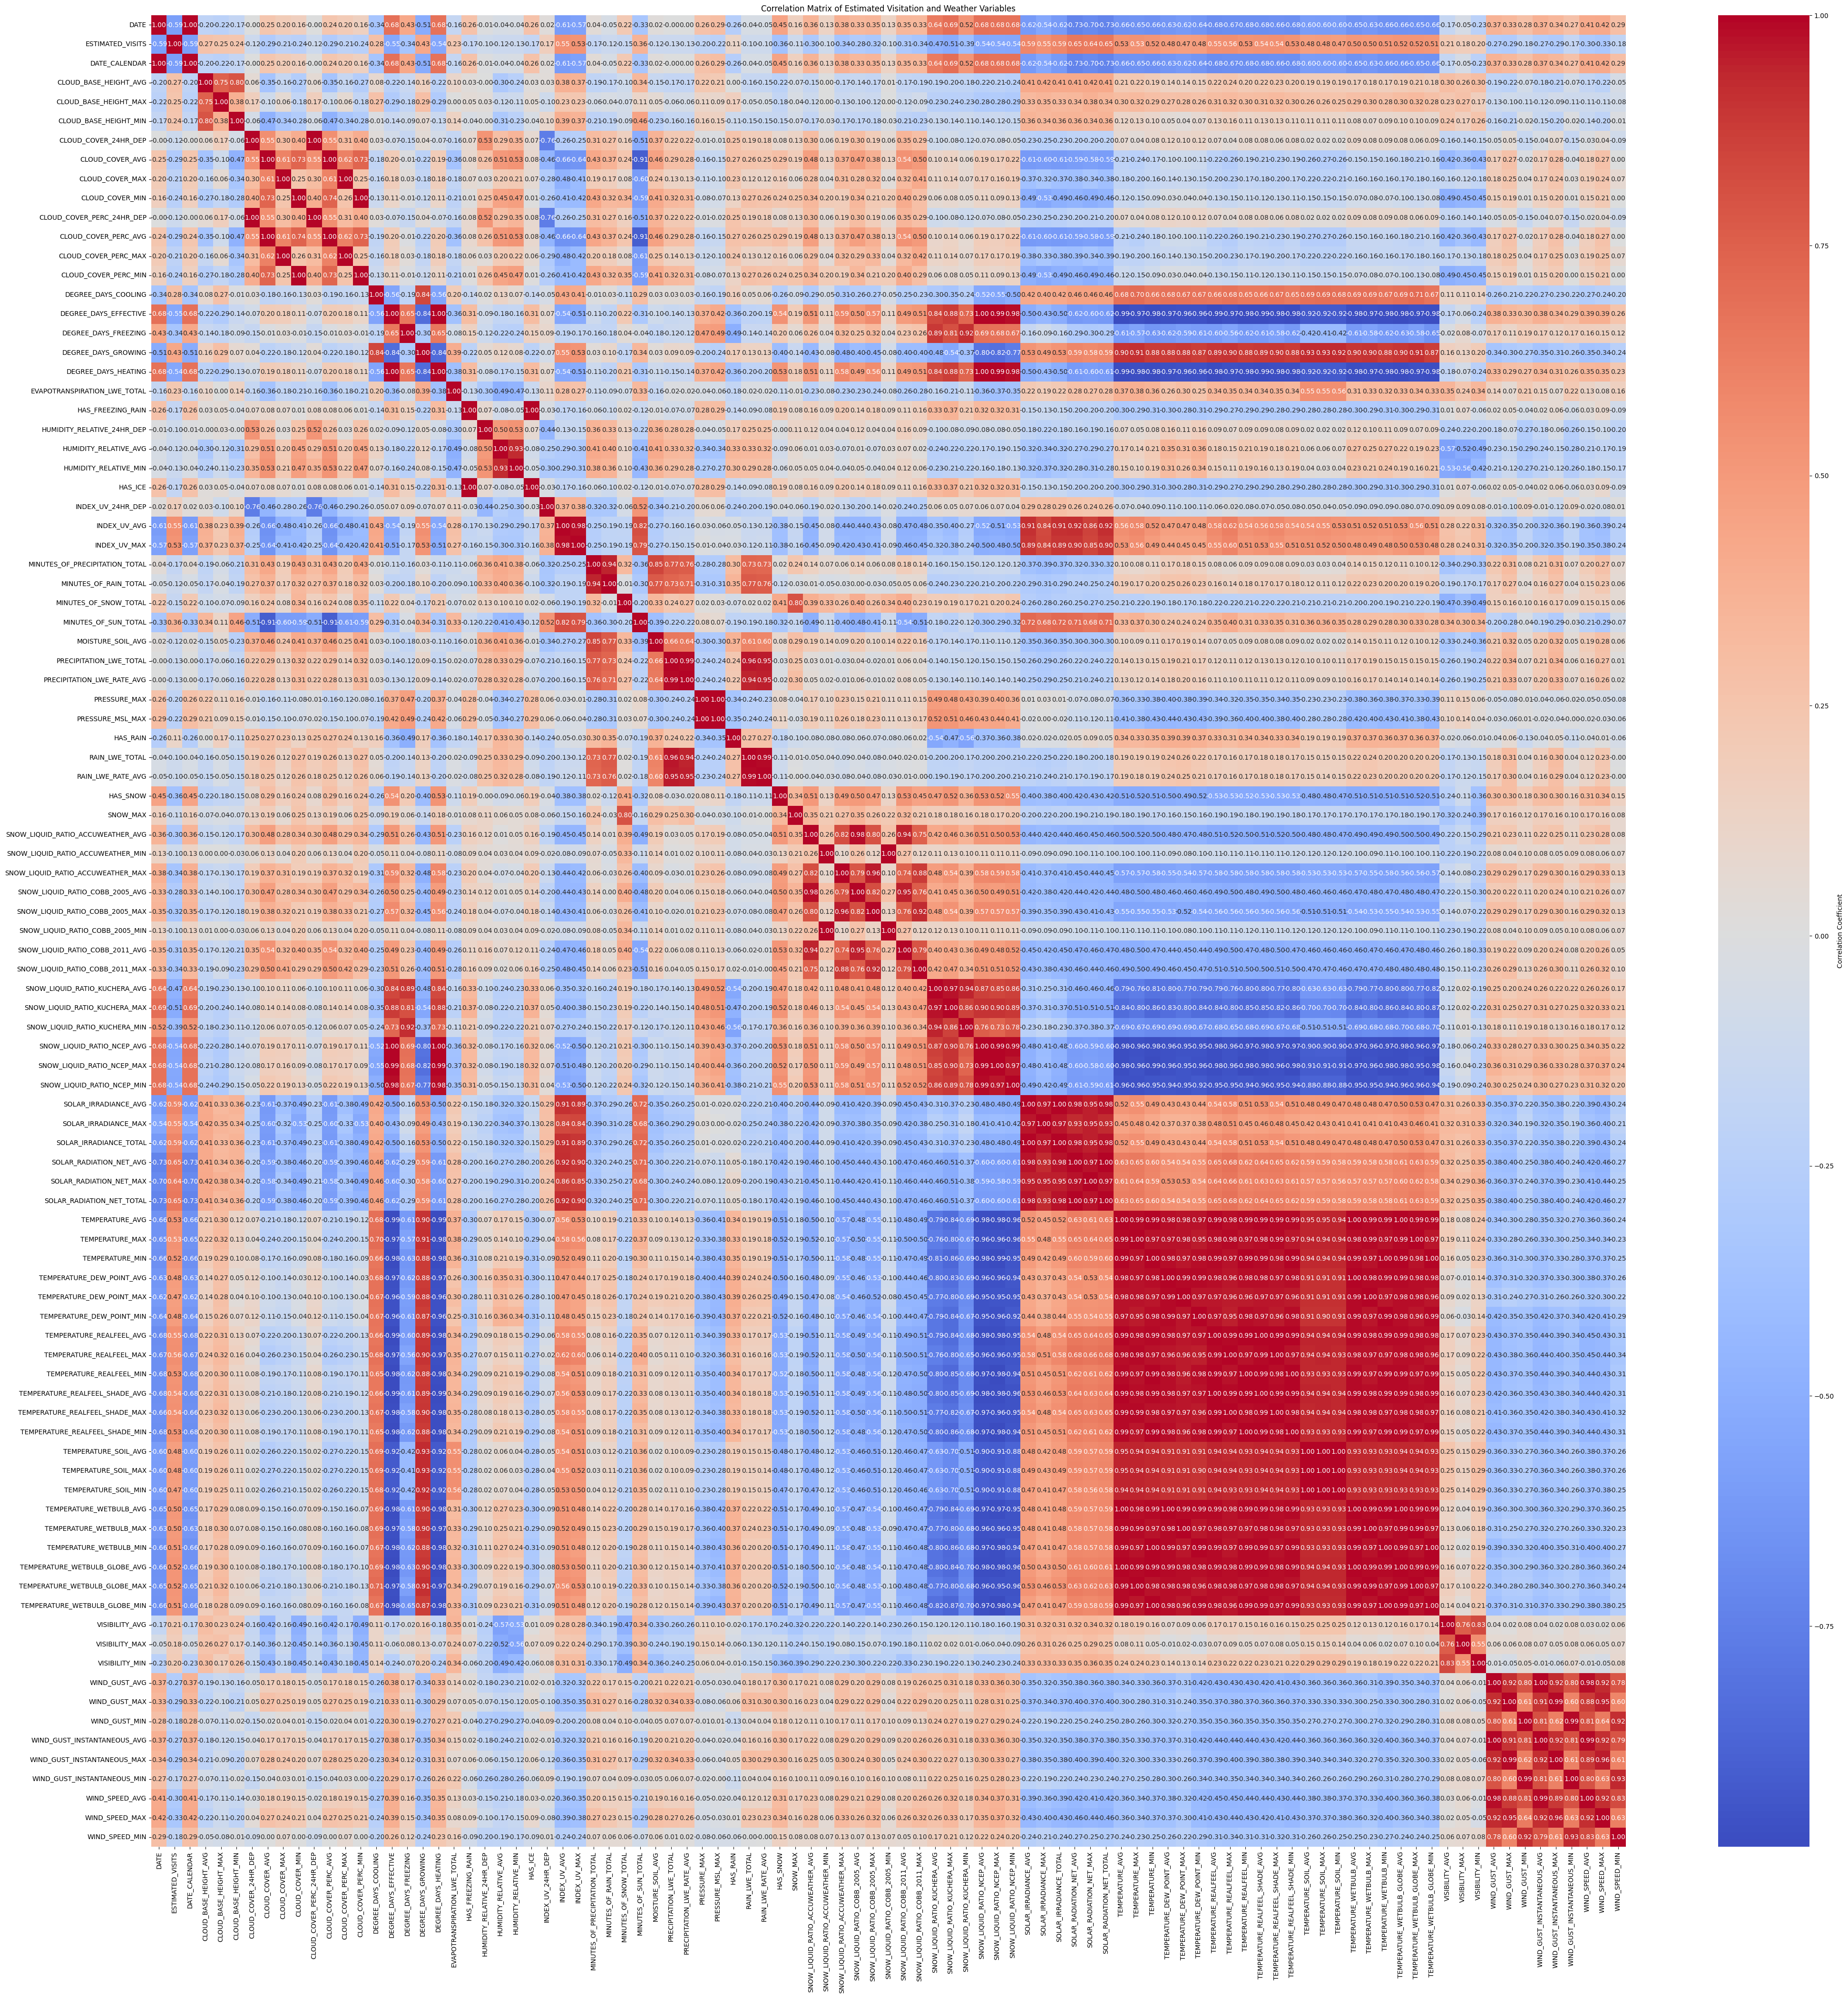

In [ ]:
# Label encode object columns
le = LabelEncoder()
for col in aligned_data.select_dtypes(include=['object']).columns:
    aligned_data[col] = le.fit_transform(aligned_data[col])

# Calculate correlation matrix
correlation_matrix = aligned_data.corr()

# Identify features with strong correlation to 'ESTIMATED_VISITS' col
strong_corr_features = correlation_matrix['ESTIMATED_VISITS'][correlation_matrix['ESTIMATED_VISITS'].abs() > 0.1].index.tolist()

# Subset the correlation matrix
reduced_matrix = correlation_matrix.loc[strong_corr_features, strong_corr_features]

# Correlation matrix plot
plt.figure(figsize=(50, 50))  # Adjust the figure size as needed
sns.heatmap(reduced_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Estimated Visitation and Weather Variables')
plt.show()


In [ ]:
# Reduce the DataFrame to selected features
reduced_data = aligned_data[strong_corr_features]

print(reduced_data.shape)

(323, 95)


Train-test set split (ratio 9:1)

I have tried to fit on two different models to find out which one works the best

In [ ]:
X = reduced_data.drop(['ESTIMATED_VISITS','DATE','DATE_CALENDAR'],axis = 1)
y = reduced_data['ESTIMATED_VISITS']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Creating and fitting the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Prediction on the test set
y_pred = model.predict(X_test)

# Evaluating the model based on MSE and R2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Model MSE results: {mse}'),
print(f'Model R2 results: {r2}')

Model MSE results: 1649693.8951995913
Model R2 results: 0.02350483241190615


In [ ]:
# Creating and fitting the RandomForest model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# Predicting on the test set with the RandomForest model
y_pred_rf = random_forest_model.predict(X_test)

# Evaluating the model based on MSE and R2
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Model MSE results: {mse_rf}'),
print(f'Model R2 results: {r2_rf}')


Model MSE results: 1119992.5695151514
Model R2 results: 0.3370483245112582


**Grid Search on randomforest model for hyper parameter tunning**

In [ ]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'random_state': [42]
}


In [ ]:
rf = RandomForestRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_estimator = grid_search.best_estimator_

# Predict using the best estimator
y_pred_best = best_estimator.predict(X_test)

# Evaluating the model based on MSE and R2
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(mse_best, r2_best, best_params)


Fitting 5 folds for each of 864 candidates, totalling 4320 fits


(1125204.2815299812,
 0.33396338153356353,
 {'bootstrap': True,
  'max_depth': None,
  'max_features': 'log2',
  'min_samples_leaf': 2,
  'min_samples_split': 10,
  'n_estimators': 100,
  'random_state': 42})

In [ ]:
# Compare with the actual result
final = pd.DataFrame(y_pred_best,y_test)
final.head(30)

0
ESTIMATED_VISITS             
3461              4154.246578
4152              4294.023881
1364              2772.351092
1875              2732.532528
3141              3622.007582
4267              4625.006259
2088              2546.299400
1502              2845.500577
1787              3008.054500
3569              3242.069189
4336              3028.626186
2654              4157.288095
1941              2200.490426
4364              4788.161481
4433              3245.306629
1976              1640.298819
4608              4770.010975
3079              4278.332615
1918              3028.242743
2915              3999.891016
3253              3143.484895
6815              5029.133314
3549              4428.800560
1773              1929.104905
3956              3333.892036
3192              4333.448023
5873              4064.052743
3227              4452.397829
2347              3492.884796
3025              2288.179388

### Additional insights - feature importance

By plot the feature importance after model training, we can find out which feature contribute more to the final results of estimate vistors which helps us for future analysis.

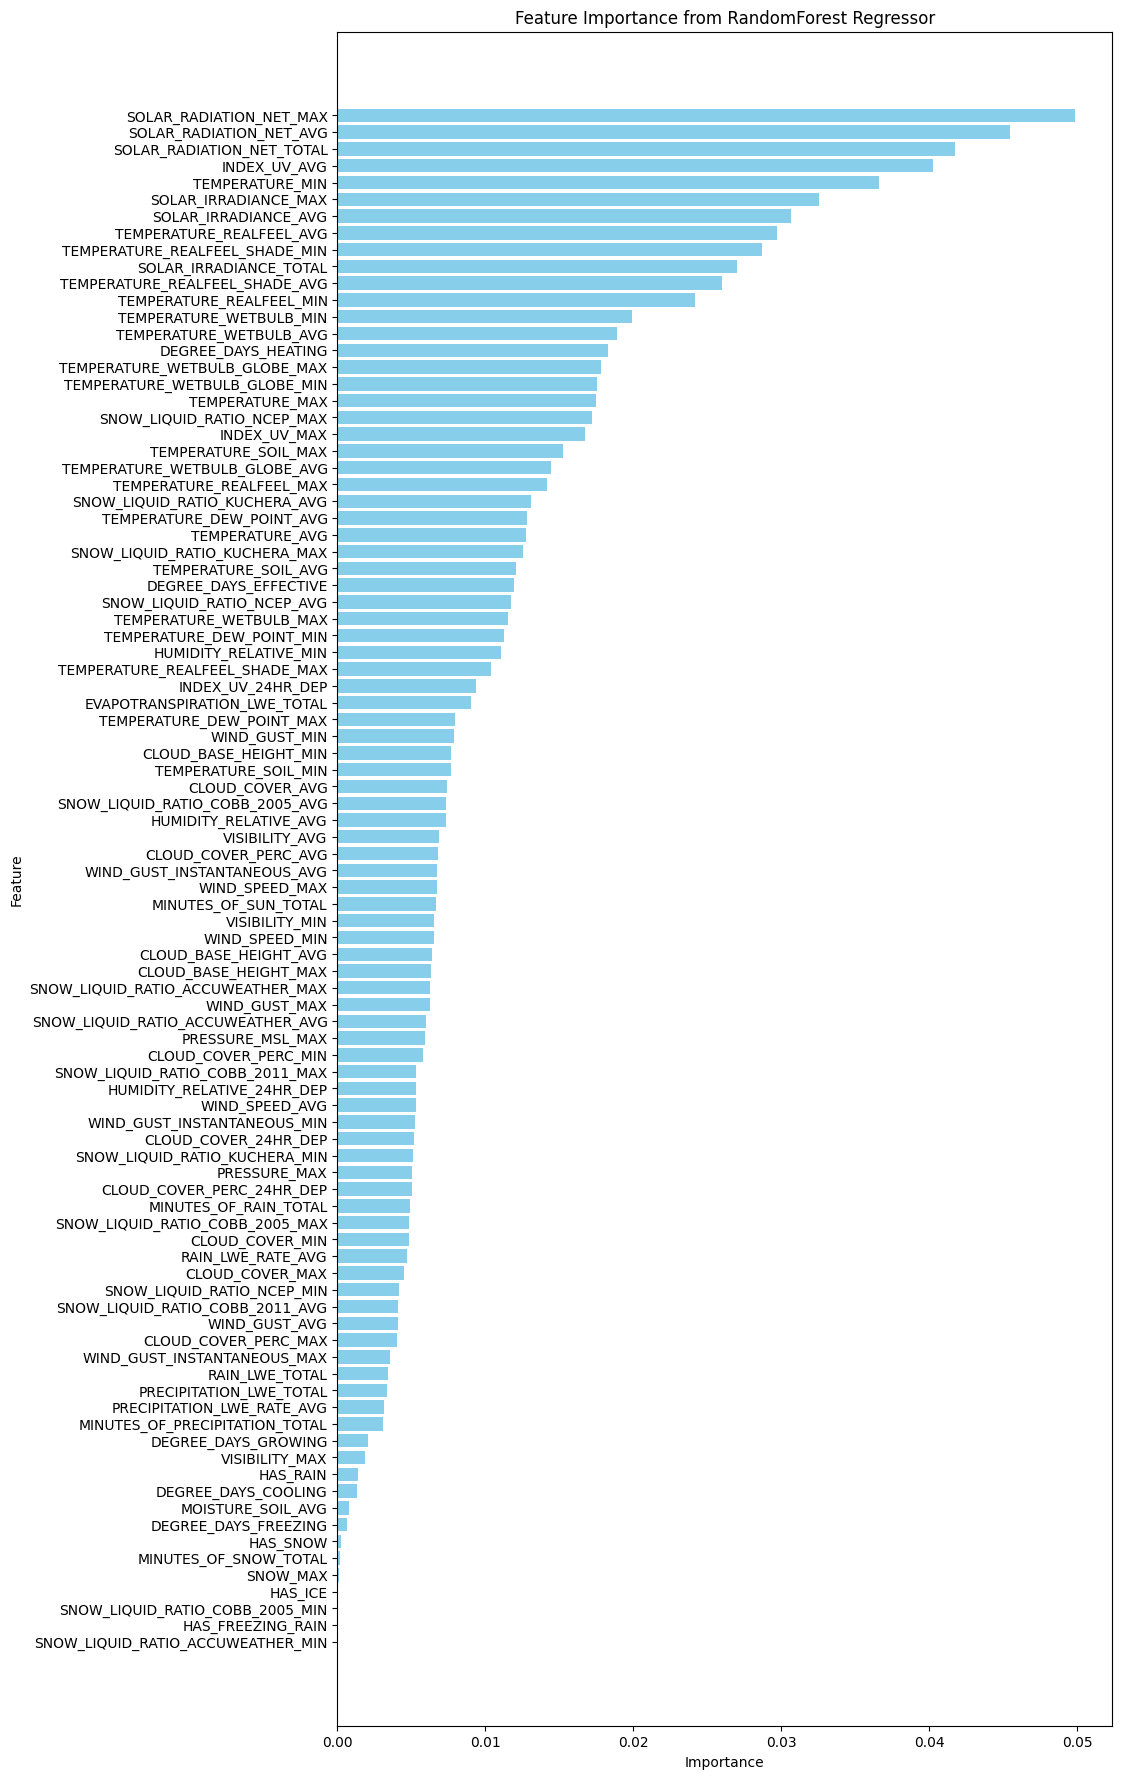

In [ ]:
# Extract feature importances from the model
feature_importances = best_estimator.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to save result
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort by importance score
importances_df = importances_df.sort_values(by='Importance', ascending=True)

# Plotting
plt.figure(figsize=(10, 22))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from RandomForest Regressor')
plt.show()

In [ ]:
!jupyter nbconvert --to html EA_Intern_assignment.ipynb

[NbConvertApp] Converting notebook EA_Intern_assignment.ipynb to html
[NbConvertApp] Writing 6696648 bytes to EA_Intern_assignment.html
